<a href="https://colab.research.google.com/github/ParamitaDas18/ML_Lab_Codes/blob/main/Q13_k_means_clustering_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

'Customer_segmentation_datasets .csv'   sample_data


In [3]:
# Download dataset (Mall Customer Segmentation Data)
import pandas as pd
url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2023.csv"
df = pd.read_csv(url)
df.to_csv("customer_segmentation.csv", index=False)

  tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  2023-9900   United Cup    Hard         18             A      20230102   
1  2023-9900   United Cup    Hard         18             A      20230102   
2  2023-9900   United Cup    Hard         18             A      20230102   
3  2023-9900   United Cup    Hard         18             A      20230102   
4  2023-9900   United Cup    Hard         18             A      20230102   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0        300     126203          3.0          NaN  ...    62.0     47.0   
1        299     126207          NaN          NaN  ...    12.0      8.0   
2        296     126203          3.0          NaN  ...    62.0     51.0   
3        295     126207          NaN          NaN  ...    41.0     26.0   
4        292     126774          1.0          NaN  ...    58.0     48.0   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_rank winner_rank_points  \
0      15.0    

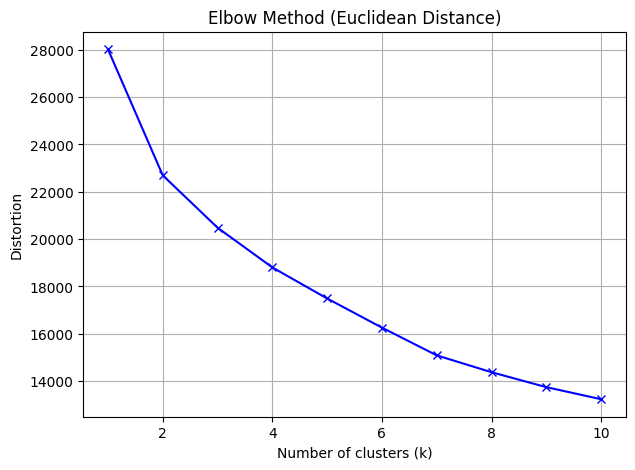

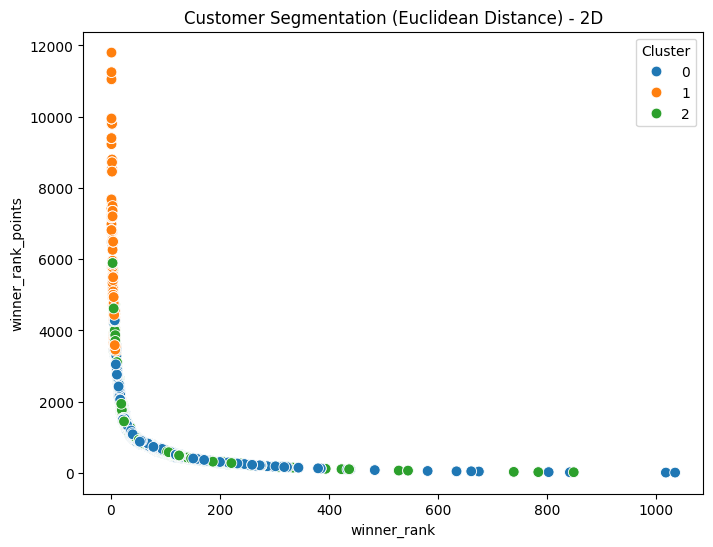

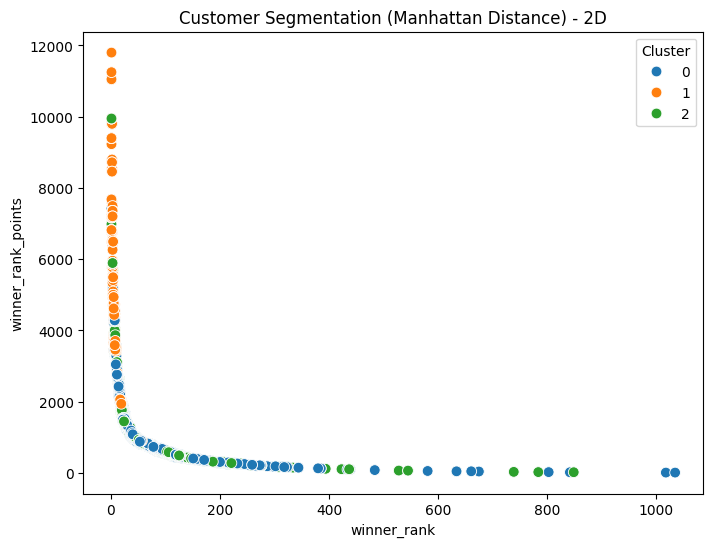

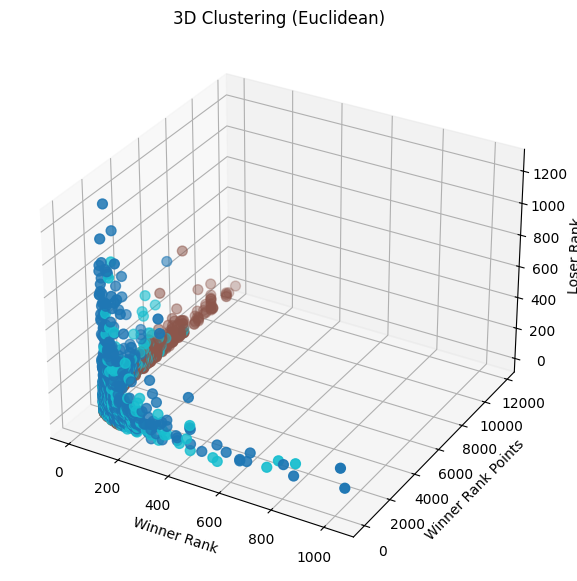

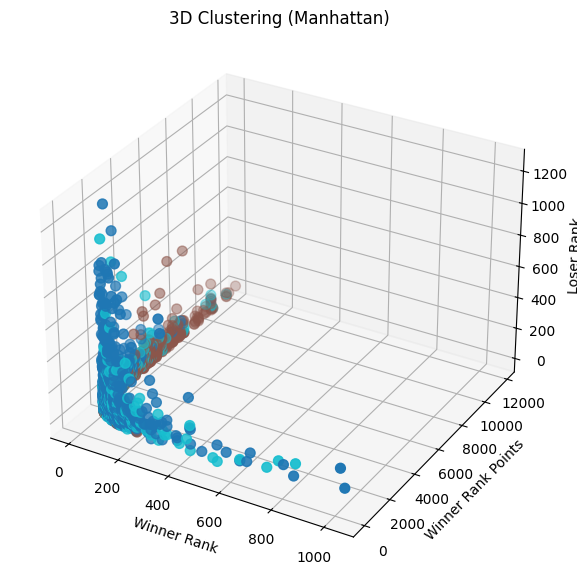

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Load dataset
df = pd.read_csv("customer_segmentation.csv")
print(df.head())

# Select relevant features for clustering (using columns from the ATP dataset)
# I'll select columns that are numerical and potentially interesting for clustering,
# such as player ranks and points, and some match statistics.
X = df[['winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt']]

# Drop rows with NaN values in the selected columns to avoid errors in clustering
X = X.dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Determine optimal number of clusters (Elbow Method) ----
# Limit K to a reasonable range based on the number of data points
K = range(1, min(11, len(X_scaled)))
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to suppress warning
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)  # Euclidean distance

if len(K) > 1:
    plt.figure(figsize=(7, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method (Euclidean Distance)')
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points to plot Elbow Method for multiple clusters.")


# ---- KMeans with Euclidean Distance ----
# Choose a number of clusters (e.g., based on the elbow method if applicable)
n_clusters = 3 # Example: choosing 3 clusters
kmeans_euclidean = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init
clusters_euclidean = kmeans_euclidean.fit_predict(X_scaled)

# Add cluster assignments back to the original dataframe (only for the rows used in clustering)
df_clustered = df.loc[X.index].copy()
df_clustered['Cluster_Euclidean'] = clusters_euclidean


# ---- KMeans with Manhattan Distance (L1) ----
# For Manhattan distance, we'll manually assign clusters using medoids or argmin distance.
# A simple workaround: assign clusters based on minimum L1 distance to Euclidean cluster centers
centers = kmeans_euclidean.cluster_centers_
manhattan_labels = np.argmin(cdist(X_scaled, centers, metric='cityblock'), axis=1)
df_clustered['Cluster_Manhattan'] = manhattan_labels

# ---- 2D Plot (Euclidean) ----
# Select two features for 2D plotting. Using 'winner_rank' and 'winner_rank_points' as examples
if len(df_clustered) > 0:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_clustered, x='winner_rank', y='winner_rank_points',
                    hue='Cluster_Euclidean', palette='tab10', s=60)
    plt.title('Customer Segmentation (Euclidean Distance) - 2D')
    plt.legend(title='Cluster')
    plt.show()

    # ---- 2D Plot (Manhattan) ----
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_clustered, x='winner_rank', y='winner_rank_points',
                    hue='Cluster_Manhattan', palette='tab10', s=60)
    plt.title('Customer Segmentation (Manhattan Distance) - 2D')
    plt.legend(title='Cluster')
    plt.show()

    # ---- 3D Plot (Euclidean) ----
    # Select three features for 3D plotting. Using 'winner_rank', 'winner_rank_points', and 'loser_rank' as examples
    if X.shape[1] >= 3:
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df_clustered['winner_rank'], df_clustered['winner_rank_points'], df_clustered['loser_rank'],
                   c=df_clustered['Cluster_Euclidean'], cmap='tab10', s=50)
        ax.set_xlabel('Winner Rank')
        ax.set_ylabel('Winner Rank Points')
        ax.set_zlabel('Loser Rank')
        ax.set_title('3D Clustering (Euclidean)')
        plt.show()

        # ---- 3D Plot (Manhattan) ----
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df_clustered['winner_rank'], df_clustered['winner_rank_points'], df_clustered['loser_rank'],
                   c=df_clustered['Cluster_Manhattan'], cmap='tab10', s=50)
        ax.set_xlabel('Winner Rank')
        ax.set_ylabel('Winner Rank Points')
        ax.set_zlabel('Loser Rank')
        ax.set_title('3D Clustering (Manhattan)')
        plt.show()
    else:
        print("Not enough features selected for 3D plotting.")

else:
    print("No data points remaining after dropping NaNs for plotting.")